### 2.2.3 분석결과


In [ ]:
# 분석에 사용할 형태소 분석기를 설치합니다.
!pip install -U PyKomoran

In [ ]:
# 네트워크 분석시 한글이 깨지는 현상을 방지합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 필요한 패키지들을 불러옵니다.
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
import re
import numpy as np
from chatspace import ChatSpace
from tqdm import tqdm
import random
import pickle
from PyKomoran import *
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction import text 

drive.mount("/content/gdrive")
os.chdir("/content/gdrive/My Drive/github/4학년2학기과제및논문/졸업논문")


%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 사용자 정의 사전을 사용하는 형태소 분석기를 불러옵니다.
from PyKomoran import *
komoran = Komoran(DEFAULT_MODEL['FULL']) 
komoran.set_user_dic('./data/user_dic.user') 

In [ ]:
# 본문 내용이 포함된 뉴스 기사 데이터를 불러와서 결측값을 제거합니다.
data = pd.read_csv("./data/aitimes_content.csv",index_col=[0])
data = data.loc[data["content"].notnull(),:].reset_index().drop(columns=["index"])

In [ ]:
# 기사별 분류 기준이 포함된 데이터프레임을 만듭니다.
a = data["classification"].apply(lambda x: x.split(" "))
b = [np.asarray(i[-1]) for i in a]
data["classification_1"] = np.stack(b).reshape(-1,1)
data["content"] = data["content"] + data["classification_1"]

In [ ]:
# 문장의 전처리 함수 입니다.
def spec(sentence):
  kor = re.compile("\W") 
  ret = kor.sub(" ",sentence)
  ret = komoran.nouns(ret) 
  ret = [j.strip() for j in ret if len(j) > 1]
  return ret

In [ ]:
# 문장의 불용어 제거 함수 입니다.
def stop_word2(list_sentence):
  blank = [] 
  stopword = ["서비스","개발","제공","기업","기반","한편","예정","이번","구축",
              "대표","분야","사업","지원","활용","솔루션","기술"]
  for kk in list_sentence:
    if kk not in stopword:
      blank.append(kk)
  return blank

In [ ]:
# 워드클라우드를 만들때 적용되는 불용어를 지정합니다.
stop_words = text.ENGLISH_STOP_WORDS.union(["서비스","개발","기업","기반","한편","예정","이번","구축",
                                            "대표","분야","사업","제공","지원","활용","솔루션","기술",
                                            "관련"])

In [ ]:
# 워드클라우드를 출력하는 함수 입니다.
def word_count(classs):
  part = data.loc[data["classification_1"]==classs,:]
  part = [i for i in part["content"]]
  

  vectorizer = CountVectorizer(
      tokenizer = spec,
      min_df = 2, # 토큰이 나타날 최소 문서 개수
      ngram_range=(1, 2),
      max_features = 100,
      stop_words = stop_words,
      )
  vect = vectorizer.fit_transform(part)
  vocab = list(vectorizer.get_feature_names())
  counts = vect.sum(axis=0).A1
  freq_distribution = Counter(dict(zip(vocab, counts)))


  wordcloud = WordCloud(max_font_size=200,
                        font_path='./data/malgun.ttf',
                        colormap = 'Accent_r',
                        width=800,height=800)
  wordcloud = wordcloud.generate_from_frequencies(freq_distribution)
  return wordcloud

In [ ]:
# 앞서 만든 워드클라우드 함수에 데이터의 카테고리별 워드클라우드를 출력하도록 합니다.
classes = ["기업","발표","의료·헬스케어","5G·네트워크","빅데이터","IoT","자율주행","챗봇","스마트시티·홈","스마트팩토리"]
plt.rcParams["figure.figsize"] = (20,20)
plt.rc('font', family='NanumBarunGothic')
fig = plt.figure(figsize=(15,15))
for i,keyword in enumerate(classes):
  wordcloud = word_count(keyword)
  ax = fig.add_subplot(5,2,i+1)  
  ax.set_title("그림"+str(i+1)+" "+keyword)
  ax.imshow(wordcloud,interpolation="bilinear")
  ax.axis('off')

In [ ]:
# 데이터의 카테고리별 나온 명사의 갯수를 출력하는 함수 입니다.
def count(classs):
  part = data.loc[data["classification_1"]==classs,:]
  part = [i for i in part["content"]]
  

  vectorizer = CountVectorizer(
      tokenizer = spec,
      min_df = 2,
      ngram_range=(1, 2),
      max_features = 100,
      stop_words = stop_words,
      )
  vect = vectorizer.fit_transform(part)
  vocab = list(vectorizer.get_feature_names())
  counts = vect.sum(axis=0).A1
  freq_distribution = Counter(dict(zip(vocab, counts)))
  return freq_distribution

In [ ]:
def f2(x):
  return x[1]

In [ ]:
fig.savefig("./data/wordcount.jpg")

In [ ]:
# 선택한 카테고리와 핵심 키워드, 지지도를 지정하여 키워드 네트워크를 출력하는 함수 입니다.
def network(group,keyword,support):

  company = data.loc[data["classification_1"] == group,:]
  content_list = [spec(i) for i in tqdm(company["content"])]
  stop_content_list = [stop_word2(k) for k in content_list]

  te = TransactionEncoder()
  te_ary = te.fit(stop_content_list).transform(stop_content_list)
  df2 = pd.DataFrame(te_ary, columns=te.columns_)
  result = apriori(df2,min_support=support,use_colnames=True,)
  df = pd.DataFrame(result)
  df["length"] = df["itemsets"].apply(lambda x: len(x))
  df = df[(df["length"]==2) & df["support"] >= 0.01].sort_values(by="support",ascending=False)
  df = df.reset_index().drop(columns=["index"])
  print("연관성 분석 완료")

  df3 = pd.DataFrame()
  for i in range(0,len(df)):
    for j in df["itemsets"][i]:
      ko = komoran.get_morphes_by_tags(keyword)
      if ko[0] or ko[1]  in j:
        df3 = df3.append(df.iloc[i,:])
  df3 = df3[(df3["length"]==2) & df3["support"] >= 0.01].sort_values(by="support",ascending=False)
  print("키워드 연관 단어 추출")

  G = nx.Graph()
  ar = (df["itemsets"]); G.add_edges_from(ar)
  """
  nx.degree_centrality()  연결중심성
  nx.betweenness_centrality() 매개중심성
  nx.closeness_centrality() 근접중심성
  nx.eigenvector_centrality() 고유벡터 중심성
  nx.pagerank()  페이지 랭크
  """
  pr = nx.degree_centrality(G)
  nsize = np.array([v for v in pr.values()])
  nsize = 2000 * (nsize - min(nsize) / (max(nsize) - min(nsize)))
  #pos = nx.random_layout(G)
  network = nx.draw_networkx(G,font_size=16,font_family="NanumBarunGothic",
                             node_color = list(pr.values()),node_size=nsize,
                             alpha=0.7,edge_color=".5",cmap=plt.cm.Blues)
  plt.title(group)
  print("시각화 완료")
  return network

100%|██████████| 69/69 [00:02<00:00, 31.21it/s]


연관성 분석 완료
키워드 연관 단어 추출
시각화 완료


/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54057 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  f

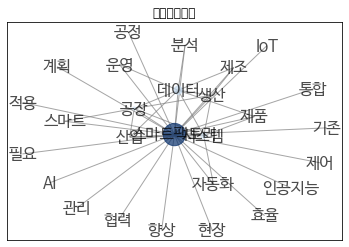

In [ ]:
network("스마트팩토리","제조",0.37)